TokaMaker Meshing Example 2: Building a mesh for HBT-EP {#doc_tMaker_mesh_ex2}
==========
In this example we show how to generate a mesh for the HBT-EP device using TokaMakers built in mesh generation.

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) and [h5py](https://www.h5py.org/) python packages. Both of which are installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import gs_Domain, save_gs_mesh

# Build mesh

## Set mesh resolution for each region
First we define some target sizes to set the resolution in out grid. These variables will be used later and represent the target edge size within a given region, where units are in meters. In this case we are using a fairly coarse resolution of 15 cm in the plasma region and 60 cm in the vacuum region. Note that when setting up a new machine these values will need to scale with the overall size of the device/domain. Additionally, one should perform a convergence study, by increasing resolution (decreasing target size) by at least a factor of two in all regions to ensure the results are not sensitive to your choice of grid size.

In [3]:
plasma_dx = 0.01
coil_dx = 0.01
vv_dx = 0.01
vac_dx = 0.06

## Load geometry information
The geometry information (eg. bounding curves for vacuum vessels) are now loaded from a JSON file. For simple geometries, testing, or generative usage this can be created directly in the code. However, it is often helpful to separate this information into a fixed datafile as here. This JSON file contains the following:
 - `limiter`: A contour of R,Z points defining the limiter (PFC) surface 
 - `inner_vv`: Two contours of R,Z points defining the inner and outer boundary of the inner vacuum vessel
 - `outer_vv`: Two contours of R,Z points defining the inner and outer boundary of the outer vacuum vessel
 - `coils`: A dictionary of R,Z,W,H values defining the PF coils as rectangles in the poloidal cross-section

In [4]:
with open('HBT_geom.json','r') as fid:
    HBT_geom = json.load(fid)

## Define regions and attributes
We now create and define the various logical mesh regions. In the ITER case we have 6 regions:
 - `air`: The region outside the vacuum vessel, which is not actually air in a complex device like ITER but we use this terminology for commonality with present research devices
 - `plasma`: The region inside the limiter where the plasma will exist
 - `vacuum1`: The region between the inner vacuum vessel and the limiter
 - `vacuum2`: The region between the inner and outer vacuum vessels
 - `vv1`: The inner vacuum vessel
 - `vv2`: The outer vacuum vessel
 - `PF1,...`: Each of the 14 coils in ITER (6 CS, 6 PF, 2 VS)

For each region you can provide a target size and one of four region types:
 - `plasma`: The region where the plasma can exist and the classic Grad-Shafranov equation with $F*F'$ and $P'$ are allowed. **There can only be one region of this type**
 - `vacuum`: A region where not current can flow and $\nabla^* \psi = 0$ is solved
 - `boundary`: A special case of the `vacuum` region, which forms the outer boundary of the computational domain. **A region of this type is required if more than one region is specified**
 - `conductor`: A region where toroidal current can flow passively (no externally applied voltage). For this type of region the resistivity should be specified with the argument `eta` in units of $\omega \mathrm{-m}$.
 - `coil`: A region where toroidal current can flow with specified amplitude through \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_currents or via shape optimization \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_reg and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_isoflux

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')    # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')    # Define the plasma region and resolution
gs_mesh.define_region('vacuum',vac_dx,'vacuum')       # Define the vacuum inside the VV
gs_mesh.define_region('shells',vv_dx,'conductor',eta=HBT_geom['vv']['eta'])  # Define the shells
gs_mesh.define_region('vv',vv_dx,'conductor',eta=HBT_geom['vv']['eta'])      # Define the VV

# Define each of the PF coils
for key, coil in HBT_geom['coils'].items():
    gs_mesh.define_region(key,coil_dx,'coil',nTurns=coil['nturns'],coil_set=key[:2])

## Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.
 1. We add the limiter contour as a "polygon", referencing `plasma` as the region enclosed by the contour and `vacuum1` as the region outside the contour.
 2. We add the inner vacuum as an "annulus" with curves defining the inner and outer edges respectively. We also reference `vacuum1` as the region enclosed by the annulus, `vv1` as the annular region itself, and `vacuum2` as the region outside the annulus.
 3. We add the outer vacuum as an "annulus" with curves defining the inner and outer edges respectively. We also reference `vacuum2` as the region enclosed by the annulus, `vv2` as the annular region itself, and `air` as the region outside the annulus.
 4. We add each of the 14 coils as "rectangles", which are defined by a center point (R,Z) along with a width (W) and height (H). We also reference `air` as the region outside the rectangle for the CS and PF coils and `vacuum1` for the VS coils.

In [6]:
# Define geometry
gs_mesh.add_polygon(HBT_geom['limiter'][:-1],'plasma',parent_name='vacuum')
gs_mesh.add_annulus(HBT_geom['vv']['vv_inner_cntr'],'vacuum', HBT_geom['vv']['vv_outer_cntr'],\
'vv',parent_name='air') # Define the shape of the VV
gs_mesh.add_polygon(HBT_geom['vv']['shell_cntr'],'shells',parent_name='vacuum') 

# Define the shape of the PF coils
for key, coil in HBT_geom['coils'].items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')


## Plot topology
After defining the logical and physical topology we can now plot the curves within the definitions to double check everything is in the right place. In cases where curves appear to cross eachother (as with the VS coil and inner VV) one should zoom in to ensure no crossings exist. In this case we had to move the upper VS coil down by 1 cm to avoid an intersection with the geometry available for this example.

Text(0, 0.5, 'Z (m)')

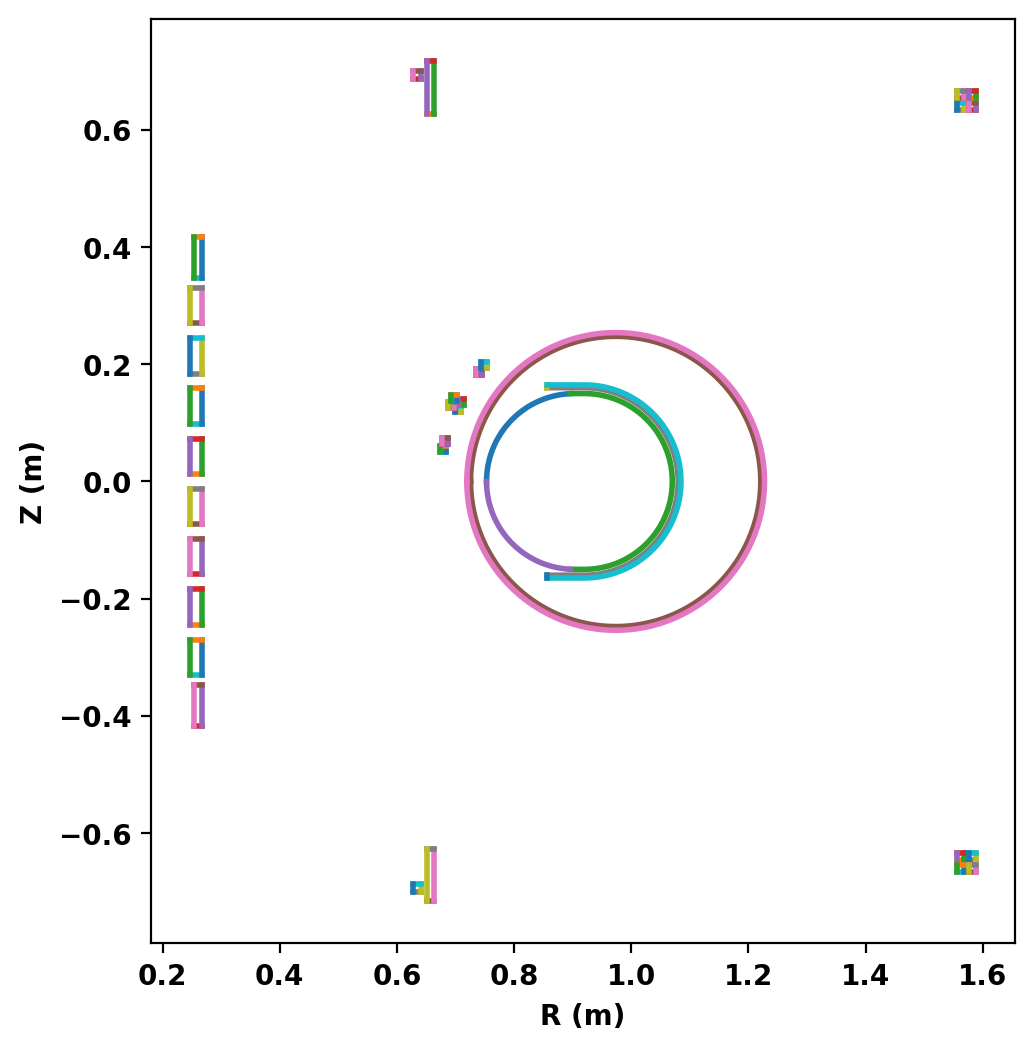

In [7]:
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

ax.set_xlabel('R (m)')
ax.set_ylabel('Z (m)')

## Create mesh
Now we generate the actual mesh using the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.build_mesh "build_mesh" method. Additionally, if `coil` and/or `conductor` regions are defined the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_coils "get_coils" and \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_conductors "get_conductors" methods should also be called to get descriptive dictionaries for later use in TokaMaker. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 905
  # of unique segments  = 135
Generating mesh:
  # of points  = 3730
  # of cells   = 7340
  # of regions = 34


## Plot resulting regions and grid
We now plot the mesh by region to inspect proper generation.

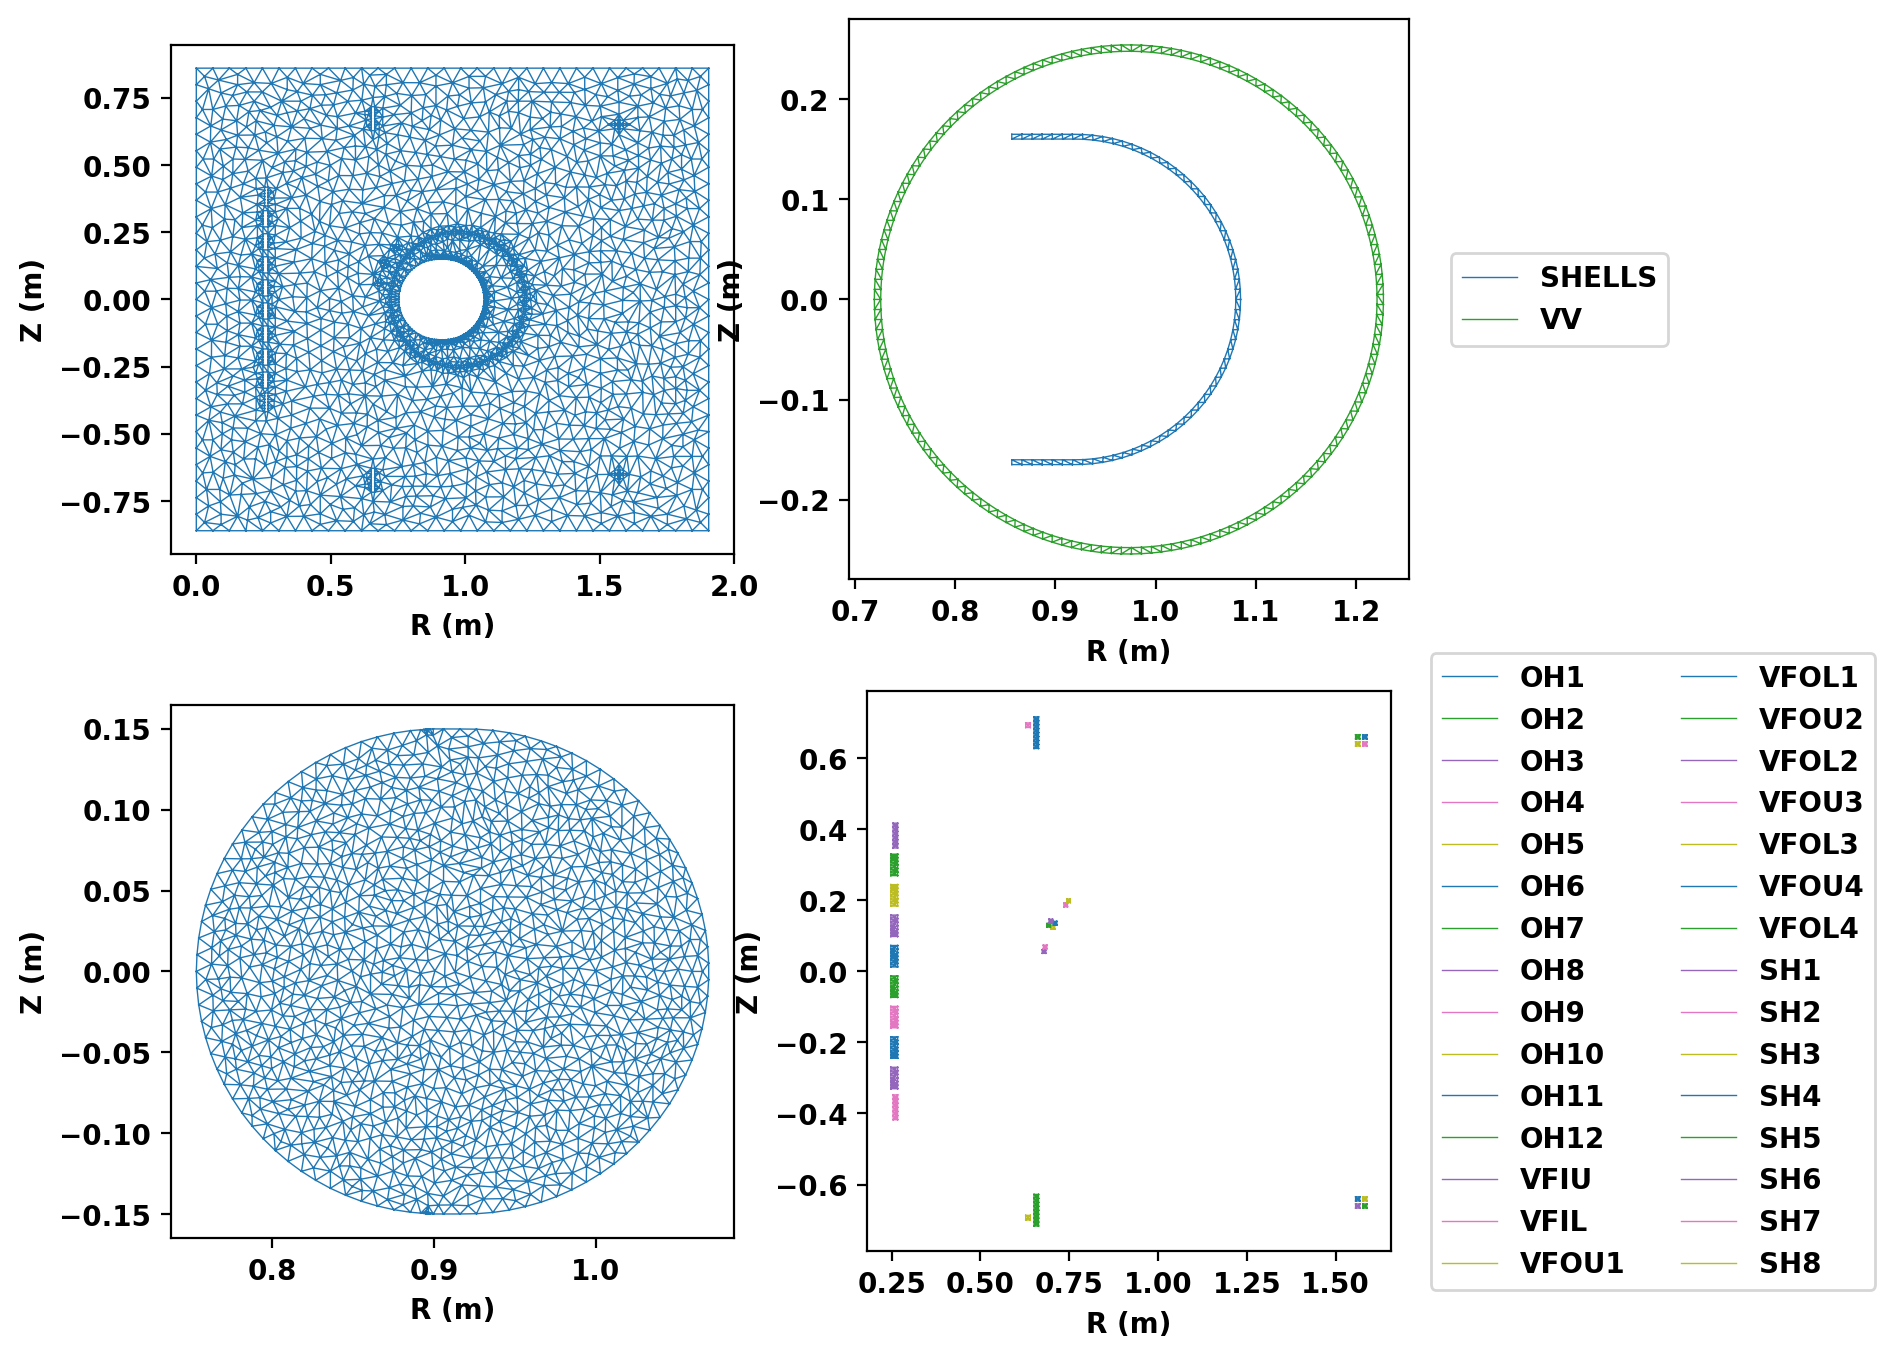

In [9]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
# Plot the vacuum regions
ax[0,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==2,:],lw=0.5)
# Plot the plasma region
ax[1,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==1,:],lw=0.5)
# Plot conductor regions
for key, cond in cond_dict.items():
    ax[0,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==cond['reg_id'],:],lw=0.5,label=key)
# Plot coil regions
for key, coil in coil_dict.items():
    ax[1,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==coil['reg_id'],:],lw=0.5,label=key)
# Format plots
for ax_tmp in ax.flatten():
    ax_tmp.set_aspect('equal','box')
ax[0,1].legend(bbox_to_anchor=(1.05,0.5), loc='center left')
_ = ax[1,1].legend(bbox_to_anchor=(1.05,0.5), ncol=2, loc='center left')

for i in range(np.shape(ax)[0]):
    for j in range(np.shape(ax)[1]):
        ax[i,j].set_xlabel('R (m)')
        ax[i,j].set_ylabel('Z (m)')


## Save mesh for later use
As generation of the mesh often takes comparable, or longer, time compare to runs in TokaMaker it is useful to separate generation of the mesh into a different script as demonstrated here. The method \ref OpenFUSIONToolkit.TokaMaker.save_gs_mesh can be used to save the resulting information for later use. This is done using and an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file through the [h5py](https://www.h5py.org/) library.

In [10]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'HBT_mesh.h5')